# Library dan Dependensi 

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
import time
import io
import base64
from IPython.display import HTML

# Set global seed for reproducibility
import os
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(42)
np.random.seed(42)
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.config.run_functions_eagerly(False)  # Disable eager execution

# Enable eager execution for compatibility
tf.config.run_functions_eagerly(True)

# Import Data

In [25]:
data = pd.read_csv('../data/fetal_health.csv')

# Eksplorasi Data

In [26]:
# Data Exploration
print("Shape of data:", data.shape)
print(data.head())
print(data.info())
print(data.describe())
print("Class distribution:")
print(data.iloc[:, -1].value_counts())

Shape of data: (2126, 22)
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0       

## Distribusi Fitur Numerik

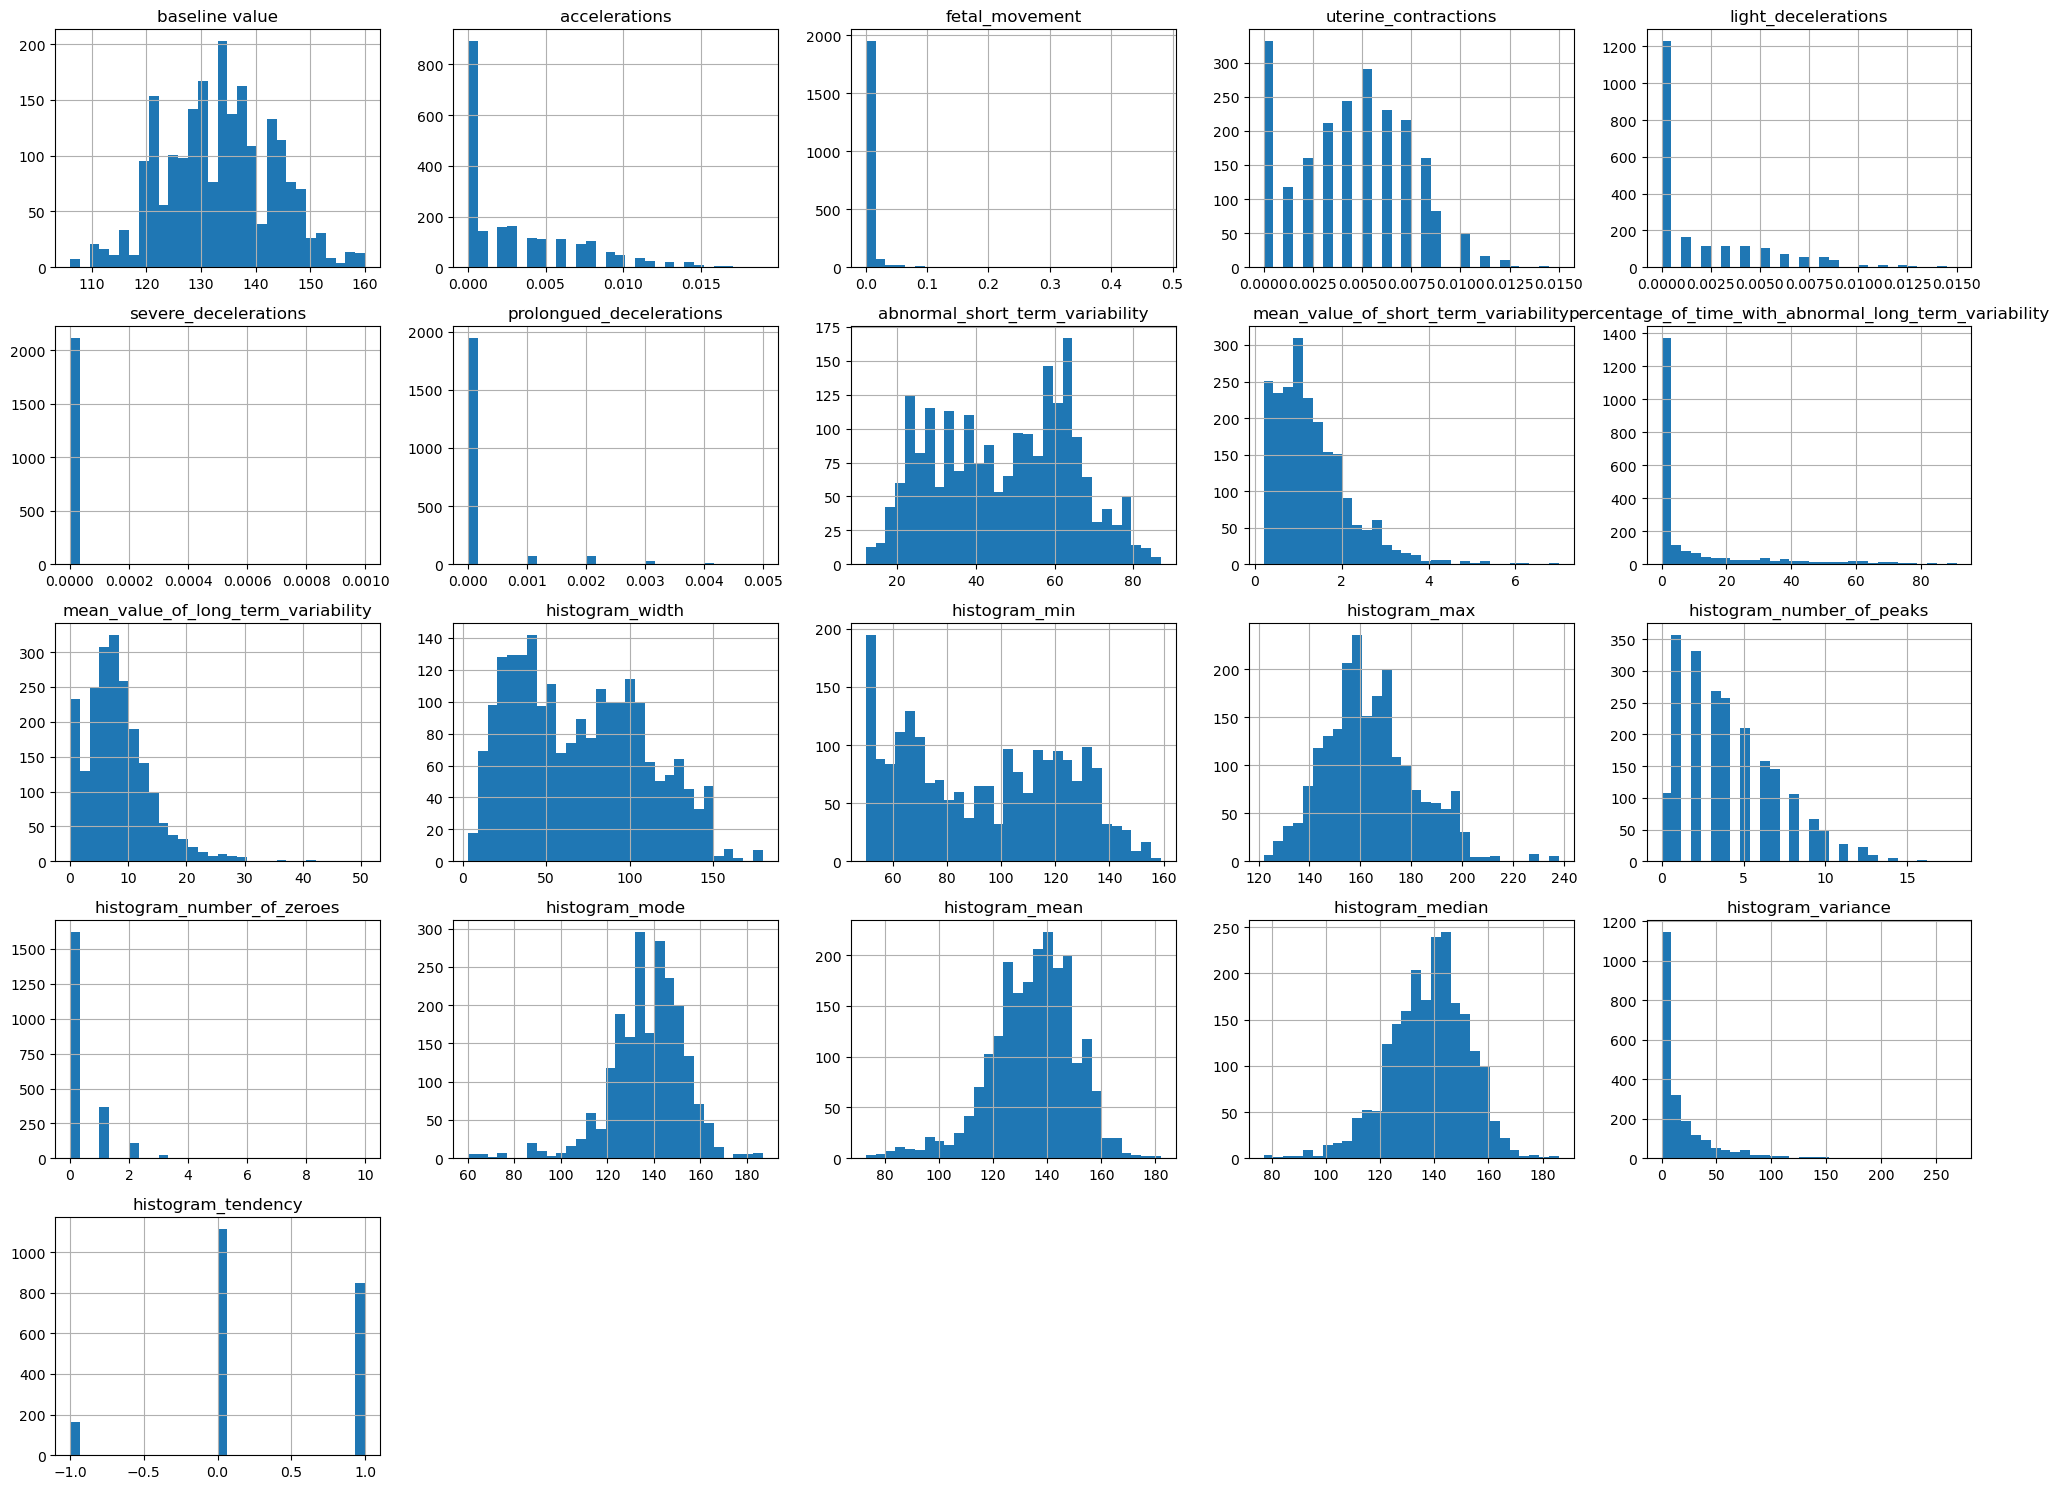

In [27]:
# Visualisasi Variabel Numerik
numerical_cols = data.select_dtypes(include=[np.number]).columns[:-1]  # Exclude target 'fetal_health'
data[numerical_cols].hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()

## Distribusi Target

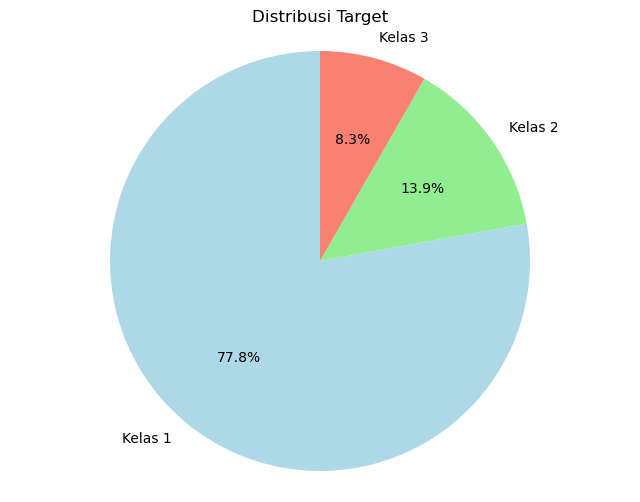

In [28]:
# Visualisasi Distribusi Target dengan Pie Chart
target_counts = data['fetal_health'].value_counts()
labels = [f'Kelas {int(k)}' for k in target_counts.index]

plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'salmon'])
plt.title('Distribusi Target')
plt.axis('equal')
plt.show()

# Praproses Data

## Splitting

In [29]:
# pisahkan target dan fitur
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

Karena loss function nya butuh kelas numerik yang dimulai dari 0, maka kelas dilakukan encoding meski sudah bentuk numerik agar dimulai dari 0

In [30]:
le = LabelEncoder()
y = le.fit_transform(y)

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# banyak train dan test 
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1700, 21)
Test set shape: (426, 21)


Distribusi train dan test

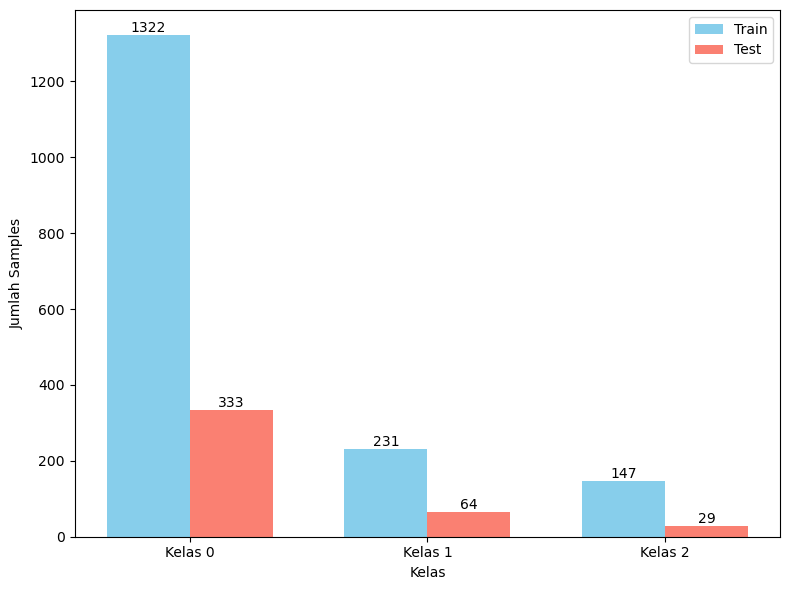

In [33]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# Pastikan semua kelas ada di kedua set (pad jika perlu)
all_classes = np.unique(np.concatenate([y_train, y_test]))
train_counts = np.zeros(len(all_classes))
test_counts = np.zeros(len(all_classes))
for i, cls in enumerate(all_classes):
    if cls in unique_train:
        train_counts[i] = counts_train[np.where(unique_train == cls)[0][0]]
    if cls in unique_test:
        test_counts[i] = counts_test[np.where(unique_test == cls)[0][0]]

# Plot grouped bar chart
x = np.arange(len(all_classes))  # posisi kelas
width = 0.35  # lebar bar

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, train_counts, width, label='Train', color='skyblue')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', color='salmon')

ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Samples')
ax.set_xticks(x)
ax.set_xticklabels([f'Kelas {int(cls)}' for cls in all_classes])
ax.legend()

# Tambahkan label nilai di atas bar
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Normalisasi

In [34]:
# Normalisasi SEBELUM balancing (fit hanya pada train asli)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit dan transform train
X_test = scaler.transform(X_test)        # Transform test (tanpa fit ulang)

### Distribusi Kelas Train Sebelum SMOTE-ENN

In [35]:
# Tampilkan distribusi kelas sebelum SMOTE-ENN
print("="*50)
print("DISTRIBUSI KELAS SEBELUM SMOTE-ENN")
print("="*50)
unique, counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)

for i, (cls, count) in enumerate(zip(unique, counts)):
    percentage = count/total_samples*100
    print(f"Kelas {cls}: {count:,} samples ({percentage:.2f}%)")

print("-"*50)
print(f"Total samples: {total_samples:,}")
print("="*50)

DISTRIBUSI KELAS SEBELUM SMOTE-ENN
Kelas 0: 1,322 samples (77.76%)
Kelas 1: 231 samples (13.59%)
Kelas 2: 147 samples (8.65%)
--------------------------------------------------
Total samples: 1,700


## SMOTE-ENN

In [36]:
# SMOTE-ENN hanya di training
smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

### Distribusi Kelas Train Setelah SMOTE-ENN

In [37]:
# Tampilkan distribusi kelas setelah SMOTE-ENN
print("="*50)
print("DISTRIBUSI KELAS SETELAH SMOTE-ENN")
print("="*50)
unique_after, counts_after = np.unique(y_train, return_counts=True)
total_samples_after = len(y_train)

for i, (cls, count) in enumerate(zip(unique_after, counts_after)):
    percentage = count/total_samples_after*100
    print(f"Kelas {cls}: {count:,} samples ({percentage:.2f}%)")

print("-"*50)
print(f"Total samples: {total_samples_after:,}")
print("="*50)

DISTRIBUSI KELAS SETELAH SMOTE-ENN
Kelas 0: 1,149 samples (30.96%)
Kelas 1: 1,264 samples (34.06%)
Kelas 2: 1,298 samples (34.98%)
--------------------------------------------------
Total samples: 3,711


## Split Train dan Val

In [38]:
# Split eksplisit untuk validation set (setelah balancing dan normalisasi)
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training full shape:", X_train_full.shape)
print("Validation shape:", X_val.shape)

Training full shape: (2968, 21)
Validation shape: (743, 21)


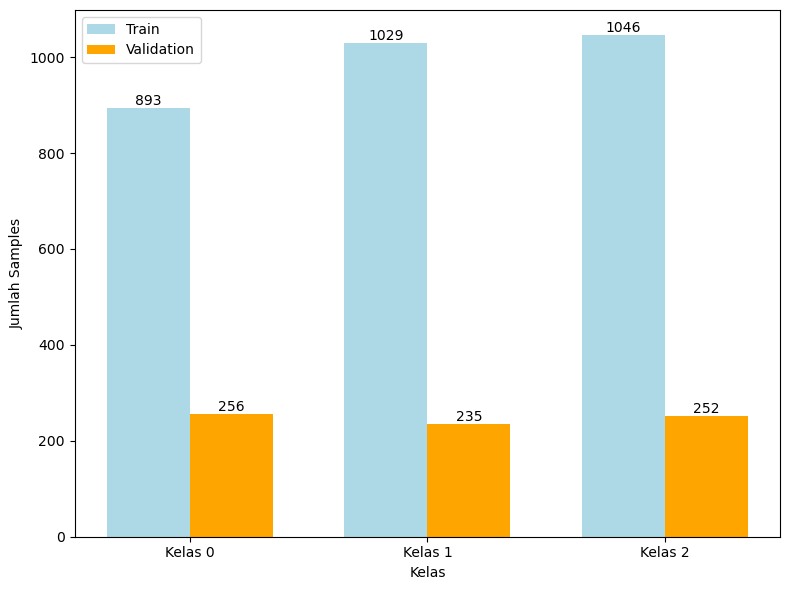

In [39]:
# Cell 26: Visualisasi distribusi kelas train_full dan val (dari train set yang sudah di-balance)

import matplotlib.pyplot as plt
import numpy as np

# Distribusi kelas untuk train_full dan val
unique_train_full, counts_train_full = np.unique(y_train_full, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

# Pastikan semua kelas ada di kedua set (pad jika perlu)
all_classes = np.unique(np.concatenate([y_train_full, y_val]))
train_full_counts = np.zeros(len(all_classes))
val_counts = np.zeros(len(all_classes))
for i, cls in enumerate(all_classes):
    if cls in unique_train_full:
        train_full_counts[i] = counts_train_full[np.where(unique_train_full == cls)[0][0]]
    if cls in unique_val:
        val_counts[i] = counts_val[np.where(unique_val == cls)[0][0]]

# Plot grouped bar chart
x = np.arange(len(all_classes))  # posisi kelas
width = 0.35  # lebar bar

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, train_full_counts, width, label='Train', color='lightblue')
bars2 = ax.bar(x + width/2, val_counts, width, label='Validation', color='orange')

ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Samples')
ax.set_xticks(x)
ax.set_xticklabels([f'Kelas {int(cls)}' for cls in all_classes])
ax.legend()

# Tambahkan label nilai di atas bar
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Eksperimen

In [40]:
# Daftar konfigurasi untuk eksperimen dengan learning rate yang sama (0.001)
learning_rate = 0.001
optimizers = ['adam', 'sgd', 'rmsprop']
activations = ['relu', 'tanh', 'sigmoid']

# Simpan hasil eksperimen
results = []
best_model = None
best_acc = 0.0

for opt_name in optimizers:
    for act in activations:
        print(f"\n--- Eksperimen: Optimizer={opt_name}, Activation={act} ---")
        
        # Buat model
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(X_train.shape[1],)),
            layers.Dense(16, activation=act),
            layers.Dense(len(np.unique(y)), activation='softmax')
        ])
        
        # Buat optimizer baru untuk setiap model
        if opt_name == 'adam':
            opt_obj = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif opt_name == 'sgd':
            opt_obj = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif opt_name == 'rmsprop':
            opt_obj = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
        # Compile model
        model.compile(optimizer=opt_obj,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_time = time.time()
        history = model.fit(X_train_full, y_train_full, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        end_time = time.time()
        runtime = end_time - start_time
        
        # Evaluate
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
        
        # Simpan model jika lebih baik
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = model  # Simpan referensi model terbaik
        
        # Compute predictions and classification report
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        report = classification_report(y_test, y_pred_classes, output_dict=True)
        
        # Extract macro averages
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']
        f1_score = report['macro avg']['f1-score']
        
        # Simpan hasil
        results.append({
            'optimizer': opt_name,
            'activation': act,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'runtime': runtime,
            'history': history.history
        })
        
        print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, Runtime: {runtime:.2f} seconds")


--- Eksperimen: Optimizer=adam, Activation=relu ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8075, Precision: 0.6563, Recall: 0.7981, F1-Score: 0.7016, Runtime: 32.75 seconds

--- Eksperimen: Optimizer=adam, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8028, Precision: 0.6677, Recall: 0.8508, F1-Score: 0.7198, Runtime: 29.83 seconds

--- Eksperimen: Optimizer=adam, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.7770, Precision: 0.6197, Recall: 0.7935, F1-Score: 0.6635, Runtime: 30.25 seconds

--- Eksperimen: Optimizer=sgd, Activation=relu ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.5352, Precision: 0.5086, Recall: 0.6842, F1-Score: 0.4778, Runtime: 20.14 seconds

--- Eksperimen: Optimizer=sgd, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.6056, Precision: 0.5264, Recall: 0.7058, F1-Score: 0.5226, Runtime: 19.88 seconds

--- Eksperimen: Optimizer=sgd, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
d:\anaconda3\envs\tfcpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\tfcpu\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

Test Accuracy: 0.1526, Precision: 0.1187, Recall: 0.4454, F1-Score: 0.1788, Runtime: 19.82 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=relu ---
Test Accuracy: 0.8052, Precision: 0.6640, Recall: 0.8224, F1-Score: 0.7112, Runtime: 25.46 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=tanh ---
Test Accuracy: 0.8052, Precision: 0.6640, Recall: 0.8224, F1-Score: 0.7112, Runtime: 25.46 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=tanh ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.8099, Precision: 0.6777, Recall: 0.8496, F1-Score: 0.7297, Runtime: 25.35 seconds

--- Eksperimen: Optimizer=rmsprop, Activation=sigmoid ---


d:\anaconda3\envs\tfcpu\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test Accuracy: 0.7723, Precision: 0.6211, Recall: 0.7915, F1-Score: 0.6653, Runtime: 24.73 seconds


# Evaluasi  
- Dapatkan kombinasi konfigurasi terbaik dari eksperimen  
- Bangun ulang model dengan konfigurasi terbaik
- Latih kembali model  
- Tampilkan performa  
- Tampilkan classification report

In [41]:
# cari konfigurasi terbaik berdasarkan f1-score
df_results = pd.DataFrame(results)
best_idx = df_results['f1_score'].idxmax()
best_config = df_results.iloc[best_idx]

print(f"Konfigurasi Terbaik: Optimizer={best_config['optimizer']}, Activation={best_config['activation']}")
print(f"F1-Score: {best_config['f1_score']:.4f}")

Konfigurasi Terbaik: Optimizer=rmsprop, Activation=tanh
F1-Score: 0.7297


# Ringkasan Eksperimen

Tabel Performa Model:
  optimizer activation  test_accuracy  test_loss  precision    recall  \
0      adam       relu       0.807512   0.502833   0.656262  0.798134   
1      adam       tanh       0.802817   0.508472   0.667708  0.850778   
2      adam    sigmoid       0.776995   0.520614   0.619696  0.793536   
3       sgd       relu       0.535211   1.022324   0.508594  0.684197   
4       sgd       tanh       0.605634   0.862418   0.526391  0.705762   
5       sgd    sigmoid       0.152582   1.479053   0.118681  0.445402   
6   rmsprop       relu       0.805164   0.503835   0.664042  0.822377   
7   rmsprop       tanh       0.809859   0.517771   0.677676  0.849573   
8   rmsprop    sigmoid       0.772300   0.527050   0.621124  0.791534   

   f1_score    runtime  
0  0.701565  32.753339  
1  0.719782  29.827298  
2  0.663478  30.252983  
3  0.477780  20.135759  
4  0.522572  19.880057  
5  0.178818  19.822412  
6  0.711168  25.460561  
7  0.729737  25.354900  
8  0.665277  24.729470

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4692\3833571005.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


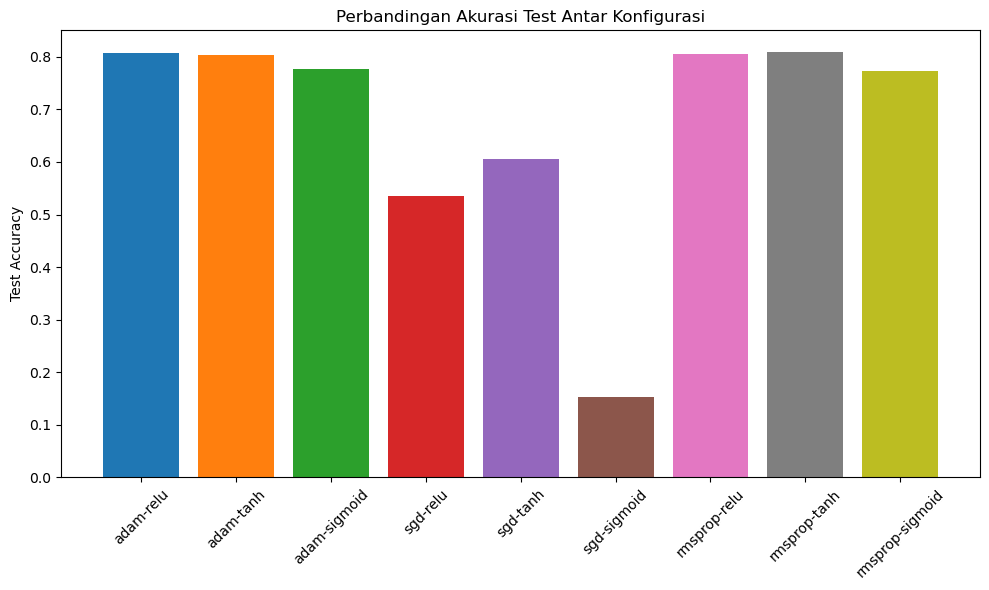


Konfigurasi Terbaik: Optimizer=rmsprop, Activation=tanh, Accuracy=0.8099, Precision=0.6777, Recall=0.8496, F1-Score=0.7297, Runtime=25.35 seconds


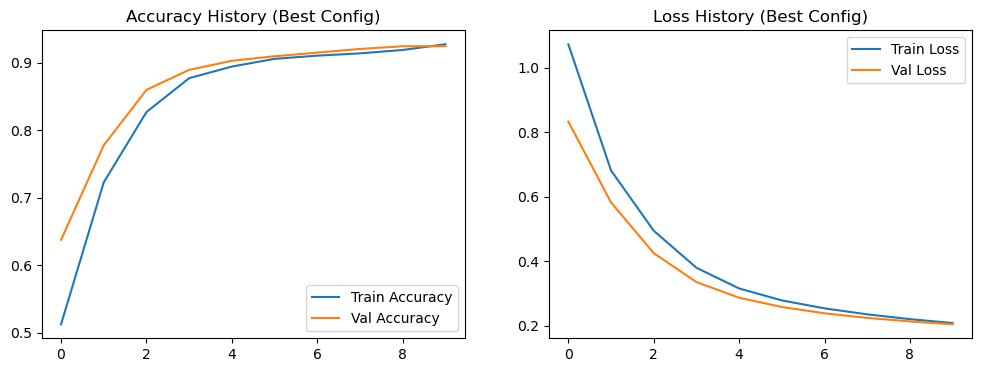

In [42]:
# Buat DataFrame dari hasil
df_results = pd.DataFrame(results)
print("Tabel Performa Model:")
print(df_results[['optimizer', 'activation', 'test_accuracy', 'test_loss', 'precision', 'recall', 'f1_score', 'runtime']])

# Plot perbandingan akurasi
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in df_results.iterrows():
    label = f"{row['optimizer']}-{row['activation']}"
    ax.bar(label, row['test_accuracy'], label=label)

ax.set_ylabel('Test Accuracy')
ax.set_title('Perbandingan Akurasi Test Antar Konfigurasi')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# Plot loss untuk konfigurasi terbaik (opsional)
best_idx = df_results['test_accuracy'].idxmax()
best_config = df_results.iloc[best_idx]
print(f"\nKonfigurasi Terbaik: Optimizer={best_config['optimizer']}, Activation={best_config['activation']}, Accuracy={best_config['test_accuracy']:.4f}, Precision={best_config['precision']:.4f}, Recall={best_config['recall']:.4f}, F1-Score={best_config['f1_score']:.4f}, Runtime={best_config['runtime']:.2f} seconds")

# Plot history untuk konfigurasi terbaik
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
plt.show()

# HTML Report

Optimizer,Activation,Test Accuracy,Test Loss,Precision,Recall,F1-Score,Runtime (seconds)
adam,relu,0.8075,0.5028,0.6563,0.7981,0.7016,32.75
adam,tanh,0.8028,0.5085,0.6677,0.8508,0.7198,29.83
adam,sigmoid,0.7770,0.5206,0.6197,0.7935,0.6635,30.25
sgd,relu,0.5352,1.0223,0.5086,0.6842,0.4778,20.14
sgd,tanh,0.6056,0.8624,0.5264,0.7058,0.5226,19.88
sgd,sigmoid,0.1526,1.4791,0.1187,0.4454,0.1788,19.82
rmsprop,relu,0.8052,0.5038,0.6640,0.8224,0.7112,25.46
rmsprop,tanh,0.8099,0.5178,0.6777,0.8496,0.7297,25.35
rmsprop,sigmoid,0.7723,0.5270,0.6211,0.7915,0.6653,24.73

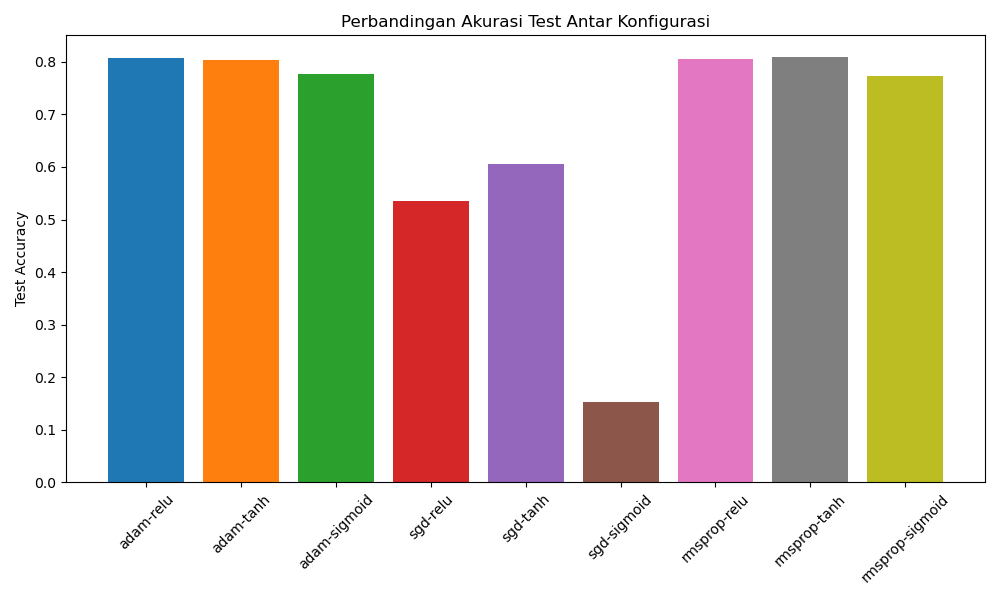
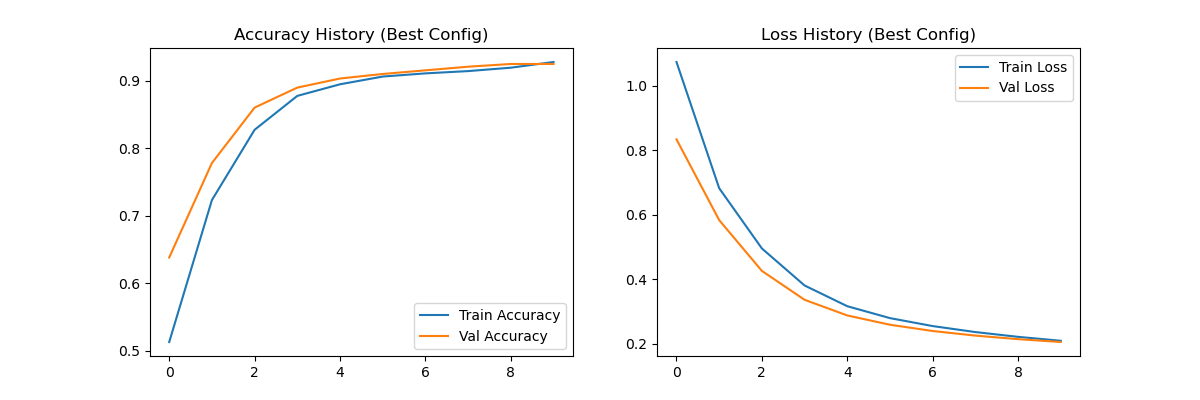

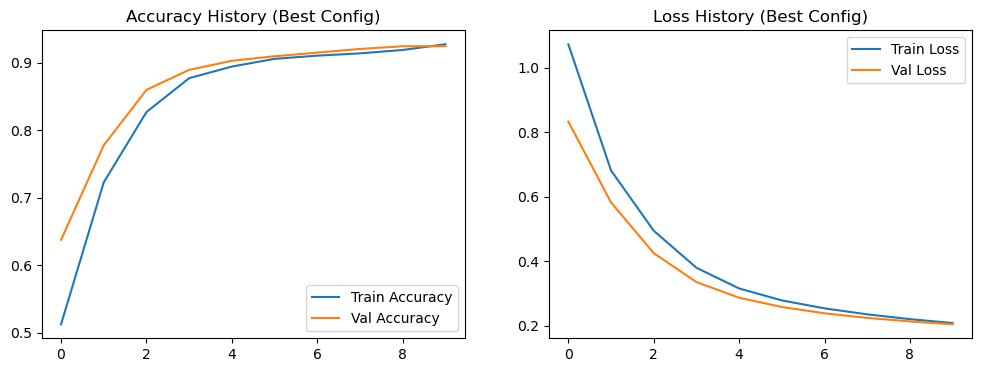

In [43]:
# Fungsi untuk mengkonversi plot ke base64
def plot_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return f"data:image/png;base64,{image_base64}"

# Buat HTML laporan
html = """
<h1>Laporan Hasil Klasifikasi</h1>

<h2>Arsitektur Model</h2>
<p>Model menggunakan arsitektur Sequential dengan layer-layer berikut:</p>
<ul>
    <li>Input(shape=(X_train.shape[1],))</li>
    <li>Dense(16, activation=activation_function)</li>
    <li>Dense(len(np.unique(y)), activation='softmax')</li>
</ul>

<h2>Parameter yang Dicoba</h2>
<p>Eksperimen dilakukan dengan kombinasi parameter berikut:</p>
<ul>
    <li><strong>Optimizer:</strong> adam, sgd, rmsprop (semua dengan learning rate 0.001)</li>
    <li><strong>Activation Function:</strong> relu, tanh, sigmoid</li>
    <li><strong>Epochs:</strong> 10</li>
    <li><strong>Batch Size:</strong> 32</li>
    <li><strong>Validation Data:</strong> eksplisit split 20% dari train set yang sudah di-balance</li>
</ul>

<h2>Hasil Setiap Percobaan</h2>
<table border="1" style="border-collapse: collapse; width: 100%;">
    <tr>
        <th>Optimizer</th>
        <th>Activation</th>
        <th>Test Accuracy</th>
        <th>Test Loss</th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1-Score</th>
        <th>Runtime (seconds)</th>
    </tr>
"""

for _, row in df_results.iterrows():
    html += f"""
    <tr>
        <td>{row['optimizer']}</td>
        <td>{row['activation']}</td>
        <td>{row['test_accuracy']:.4f}</td>
        <td>{row['test_loss']:.4f}</td>
        <td>{row['precision']:.4f}</td>
        <td>{row['recall']:.4f}</td>
        <td>{row['f1_score']:.4f}</td>
        <td>{row['runtime']:.2f}</td>
    </tr>
"""

html += """
</table>

<h2>Konfigurasi Terbaik</h2>
<p>Konfigurasi terbaik berdasarkan test accuracy tertinggi:</p>
<ul>
    <li><strong>Optimizer:</strong> """ + str(best_config['optimizer']) + """</li>
    <li><strong>Activation:</strong> """ + str(best_config['activation']) + """</li>
    <li><strong>Test Accuracy:</strong> """ + f"{best_config['test_accuracy']:.4f}" + """</li>
    <li><strong>Test Loss:</strong> """ + f"{best_config['test_loss']:.4f}" + """</li>
    <li><strong>Precision:</strong> """ + f"{best_config['precision']:.4f}" + """</li>
    <li><strong>Recall:</strong> """ + f"{best_config['recall']:.4f}" + """</li>
    <li><strong>F1-Score:</strong> """ + f"{best_config['f1_score']:.4f}" + """</li>
    <li><strong>Runtime:</strong> """ + f"{best_config['runtime']:.2f} seconds" + """</li>
</ul>

<h2>Grafik Perbandingan Akurasi Pada Data Test</h2>
<img src=\"""" + plot_to_base64(fig) + """\" alt="Perbandingan Akurasi" style="width:100%; max-width:800px;">

<h2>History Training untuk Konfigurasi Terbaik</h2>
"""

# Buat plot history lagi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_config['history']['accuracy'], label='Train Accuracy')
plt.plot(best_config['history']['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy History (Best Config)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_config['history']['loss'], label='Train Loss')
plt.plot(best_config['history']['val_loss'], label='Val Loss')
plt.title('Loss History (Best Config)')
plt.legend()
history_fig = plt.gcf()
html += """<img src=\"""" + plot_to_base64(history_fig) + """\" alt="History Training" style="width:100%; max-width:800px;">"""

html += """
</body>
</html>
"""

display(HTML(html))

In [44]:
# simpan laporan ke file HTML
with open('final_report_classification.html', 'w') as f:
    f.write(html)

In [45]:
# save keras
best_model.save('best_fetal_model.keras')

# save h5
best_model.save('best_fetal_model.h5')